ECS 174 Final Project
=====================
### Team Members:
- **Name:** Mo Elmashad
- **Name:** Sofia Cho
- **Name:** Nadia Balbontin-Ponce

### Project Description:
The goal of this project is to create a CNN model that can classify images ASL (American Sign Language) letters. The dataset we are using is the ASL Alphabet dataset from Kaggle. The dataset contains 87,000 images of 200x200 pixels. The images are in RGB format and are divided into 29 classes (26 letters of the alphabet, space, delete, and nothing). The dataset is divided into 29 folders, each folder containing images of a specific class. The dataset is divided into training and testing sets. The training set contains 29 folders, each containing 3000 images of a specific class. The testing set contains 29 folders, each containing 300 images of a specific class. 

## Installing the dataset
The dataset can be downloaded {here}[https://www.kaggle.com/grassknoted/asl-alphabet]
We  add in our kaggle.json file to the root directory of the project to download the dataset.
After downloading the dataset, we unzip the file and move the folders to the root directory of the project.

In [6]:
# imports
import matplotlib.pyplot as plt
import os


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
! pip install -q kaggle

from google.colab import files

files.upload()

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets list

!kaggle datasets download -d grassknoted/asl-alphabet

! mkdir data
! unzip asl-alphabet.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: data/asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: data/asl_alphabet_train/asl_alphabet_

In [3]:
# Function to plot the training and validation accuracy and loss
def plot_history(history, model_name):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Save the plot
    plt.savefig(f'figures/{model_name}_history.png')
    plt.show()




# Model #1 - CNN

## Preprocessing and Convolutional Neural Network (CNN) Explanation

### Preprocessing Steps

1. **Data Augmentation:**
   - **ImageDataGenerator:** Utilized to perform real-time data augmentation. The augmentation techniques applied include:
     - **Rescaling:** All pixel values are scaled to the range [0, 1] by dividing by 255.0.
     - **Rotation:** Images are randomly rotated by up to 20 degrees.
     - **Width and Height Shifts:** Images are randomly shifted horizontally and vertically by up to 20%.
     - **Shearing:** Shear transformations are applied up to 20%.
     - **Zooming:** Images are randomly zoomed in or out by up to 20%.
     - **Horizontal Flipping:** Images are randomly flipped horizontally.
     - **Fill Mode:** When transformations result in missing pixels, the nearest mode is used to fill in new pixels.

2. **Data Splitting:**
   - **Training and Validation Generators:** The dataset is split into training (80%) and validation (20%) sets.
     - **Directory Flow:** Both training and validation data are loaded from the specified directory with a target image size of 200x200 pixels and converted to grayscale.
     - **Batch Size:** Images are processed in batches of 32.
     - **Class Mode:** Categorical, as it is a multi-class classification problem.

### CNN Architecture

1. **Convolutional Layers:**
   - **Conv2D Layers:** Four convolutional layers with increasing filter sizes (32, 64, 128, and 256) are used to extract features from the input images. Each convolutional layer uses a (3, 3) kernel size and ReLU activation function.
   - **Batch Normalization:** Applied after each convolutional layer to normalize the output and speed up the training process.
   - **MaxPooling2D:** After each convolutional block, a max pooling layer with a (2, 2) pool size is used to reduce the spatial dimensions of the feature maps.
   - **Dropout:** Dropout layers are included to prevent overfitting by randomly setting a fraction of input units to zero during training.

2. **Fully Connected Layers:**
   - **Flatten:** The output of the last convolutional layer is flattened to create a 1D feature vector.
   - **Dense Layers:** A dense layer with 256 neurons and ReLU activation is used to learn complex representations. Batch normalization and dropout are again applied.
   - **Output Layer:** The final dense layer has as many neurons as the number of classes, with a softmax activation function to output class probabilities.

### Model Compilation and Training

1. **Optimizer:** 
   - **RMSprop:** The RMSprop optimizer is used with a learning rate of 0.0001.
   
2. **Loss Function:** 
   - **Categorical Crossentropy:** This is used as the loss function since it is a multi-class classification problem.
   
3. **Metrics:** 
   - **Accuracy:** The accuracy metric is tracked during training.

4. **Callbacks:**
   - **Early Stopping:** Stops training if the validation loss does not improve for 5 consecutive epochs, restoring the best model weights.
   - **Model Checkpoint:** Saves the model with the best validation loss during training.

5. **Model Training:**
   - The model is trained for 12 epochs using the augmented training and validation datasets.


In [ ]:
# Define the path to the dataset
dataset_path = 'data/asl_alphabet_train/asl_alphabet_train'

datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create data generators for training and validation sets
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(200, 200),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(200, 200),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 1)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(len(train_generator.class_indices), activation='softmax')
    ])
    return model

# Create the model
model = create_model()

# Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.1

lr_scheduler = LearningRateScheduler(scheduler)

# Print the model summary
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    train_generator,
    epochs=12,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

# Create a directory to save the plots
os.makedirs('figures', exist_ok=True)



Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.
Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 198, 198, 32)      320       
                                                                 
 batch_normalization_5 (Bat  (None, 198, 198, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 99, 99, 32)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 99, 99, 32)        0         
                                                                 
 conv2d_5 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2175/2175 [==============================] - 301s 138ms/step - loss: 2.3589 - accuracy: 0.3004 - val_loss: 16.1902 - val_accuracy: 0.0844 - lr: 1.0000e-04
Epoch 3/12
2175/2175 [==============================] - 301s 138ms/step - loss: 1.8651 - accuracy: 0.4283 - val_loss: 47.6917 - val_accuracy: 0.0455 - lr: 1.0000e-04
Epoch 4/12
2175/2175 [==============================] - 300s 138ms/step - loss: 1.5147 - accuracy: 0.5286 - val_loss: 50.6848 - val_accuracy: 0.0517 - lr: 1.0000e-04
Epoch 5/12
2175/2175 [==============================] - 300s 138ms/step - loss: 1.2533 - accuracy: 0.6050 - val_loss: 85.5630 - val_accuracy: 0.0584 - lr: 1.0000e-04
Epoch 6/12
2175/2175 [==============================] - 300s 138ms/step - loss: 1.0552 - accuracy: 0.6675 - val_loss: 27.3406 - val_accuracy: 0.0809 - lr: 1.0000e-04
Epoch 7/12
2175/2175 [==============================] - 301s 138ms/step - loss: 0.9098 - accuracy: 0.7133 - val_loss: 75.3684 - val_accuracy: 0.0451 - lr: 1.0000e-04


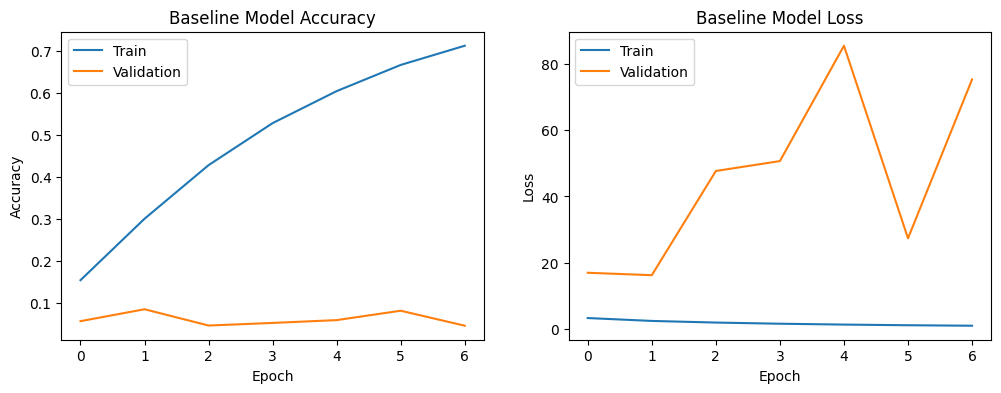

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 198, 198, 32)      320       
                                                                 
 batch_normalization_15 (Ba  (None, 198, 198, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 99, 99, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 99, 99, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 97, 97, 64)        18496     
                                                                 
 batch_normalization_16 (Ba  (None, 97, 97, 64)       

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2175/2175 [==============================] - 302s 137ms/step - loss: 2.5576 - accuracy: 0.2745 - val_loss: 3.4511 - val_accuracy: 0.2112 - lr: 0.0010
Epoch 2/12
2175/2175 [==============================] - 299s 138ms/step - loss: 1.2792 - accuracy: 0.5851 - val_loss: 3.4254 - val_accuracy: 0.2524 - lr: 0.0010
Epoch 3/12
2175/2175 [==============================] - 297s 137ms/step - loss: 0.8625 - accuracy: 0.7134 - val_loss: 1.9475 - val_accuracy: 0.4341 - lr: 0.0010
Epoch 4/12
2175/2175 [==============================] - 297s 137ms/step - loss: 0.6651 - accuracy: 0.7777 - val_loss: 3.7052 - val_accuracy: 0.3243 - lr: 0.0010
Epoch 5/12
2175/2175 [==============================] - 297s 137ms/step - loss: 0.5755 - accuracy: 0.8090 - val_loss: 1.2089 - val_accuracy: 0.6487 - lr: 0.0010
Epoch 6/12
2175/2175 [==============================] - 296s 136ms/step - loss: 0.4800 - accuracy: 0.8394 - val_loss: 2.3622 - val_accuracy: 0.5064 - lr: 0.0010
Epoch 7/12
2175/2175 [=======================

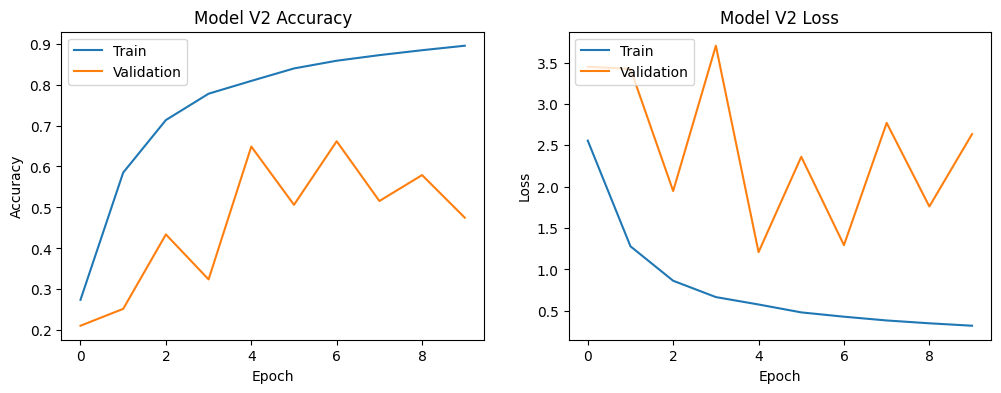

In [ ]:

plot_history(history, 'Baseline Model')

# Model with different hyperparameters
def create_model_v2():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 1)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(len(train_generator.class_indices), activation='softmax')
    ])
    return model

model_v2 = create_model_v2()
model_v2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_v2.summary()

history_v2 = model_v2.fit(
    train_generator,
    epochs=12,
    validation_data=validation_generator,
    callbacks=[early_stopping, ModelCheckpoint('best_model_v2.h5', monitor='val_loss', save_best_only=True), lr_scheduler]
)

plot_history(history_v2, 'Model V2')



## Modifications in the Second Model (Model V2)

### Changes Made

1. **Optimizer:**
   - **From RMSprop to Adam:**
     - The optimizer was changed from RMSprop to Adam. Adam (Adaptive Moment Estimation) combines the advantages of RMSprop and momentum, leading to faster convergence and better performance in many cases. This change aims to enhance the training process and potentially achieve better accuracy.

### Rationale for Changes

1. **Switching to the Adam Optimizer:**
   - **Advantages of Adam:**
     - Adam is known for its efficiency in training deep neural networks. It adapts the learning rate for each parameter, which can lead to better performance and faster convergence compared to RMSprop.
     - By using Adam, the model might benefit from improved learning dynamics, especially in scenarios where RMSprop might not perform optimally.



Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                     

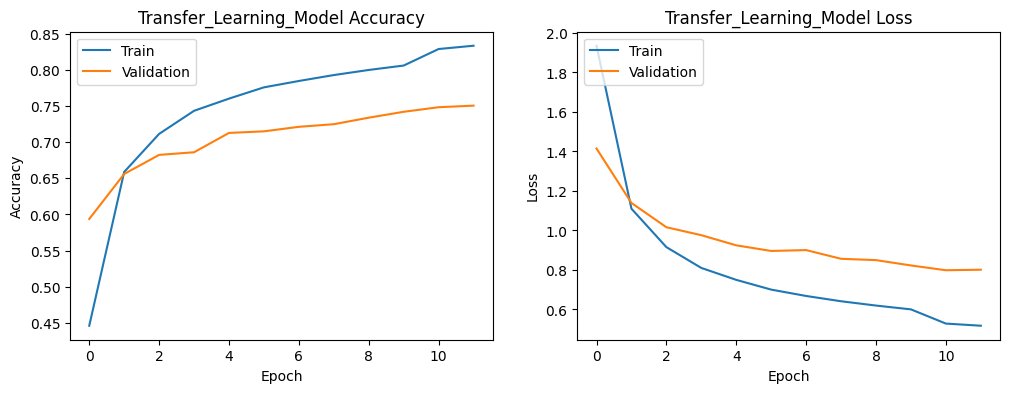

In [ ]:


# Adjust the ImageDataGenerator to load images in RGB format
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(200, 200),
    color_mode='rgb',  # Change color mode to 'rgb'
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(200, 200),
    color_mode='rgb',  # Change color mode to 'rgb'
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Transfer Learning with VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))  # Note the input shape

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

model_v3 = Model(inputs=base_model.input, outputs=predictions)
model_v3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model_v3.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_v3.h5', monitor='val_loss', save_best_only=True)
lr_scheduler = LearningRateScheduler(scheduler)

# Train the model
history_v3 = model_v3.fit(
    train_generator,
    epochs=12,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

# Function to plot the training and validation accuracy and loss
def plot_history(history, model_name):
    # Create a directory to save the plots
    os.makedirs('figures', exist_ok=True)

    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Save the plot
    plt.savefig(f'figures/{model_name}_history.png')
    plt.show()

# Plot and save history for the transfer learning model
plot_history(history_v3, 'Transfer_Learning_Model')


## Modifications in the Third Model (Transfer Learning with VGG16)

### Changes Made

1. **Image Data Loading:**
   - **From Grayscale to RGB:**
     - The `color_mode` in the `ImageDataGenerator` was changed from `'grayscale'` to `'rgb'`. This adjustment means that images are now loaded in RGB format instead of grayscale.

2. **Model Architecture:**
   - **Transfer Learning with VGG16:**
     - The model architecture was changed to use the VGG16 pre-trained model from the ImageNet dataset.
     - **Layers of VGG16:**
       - The base model includes all convolutional and pooling layers from VGG16, excluding the top (fully connected) layers.
     - **Freezing Layers:**
       - All layers of the VGG16 base model are set to non-trainable to retain the learned features from ImageNet.

3. **Adding Custom Layers:**
   - **Global Average Pooling:**
     - A `GlobalAveragePooling2D` layer is added after the VGG16 base model to reduce the spatial dimensions of the feature maps.
   - **Dense Layer:**
     - A dense layer with 256 neurons and ReLU activation is added for learning new features specific to the ASL alphabet dataset.

### Rationale for Changes

1. **Using RGB Images:**
   - **Leveraging Color Information:**
     - Loading images in RGB format allows the model to leverage color information, which can be beneficial if the color provides important features for distinguishing between different classes.

2. **Transfer Learning with VGG16:**
   - **Pre-trained Features:**
     - VGG16 is a well-established deep convolutional neural network trained on the large ImageNet dataset. By using its pre-trained weights, the model can benefit from robust feature extraction capabilities, reducing the need for extensive training on the new dataset.
   - **Efficiency:**
     - Freezing the layers of VGG16 ensures that the pre-trained features are retained, which can lead to faster convergence and better performance, especially when the new dataset is relatively small.

3. **Custom Layers:**
   - **Adaptation to New Dataset:**
     - Adding custom dense and dropout layers allows the model to adapt the pre-trained features to the specific characteristics of the ASL alphabet dataset, enhancing its classification capabilities.

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0   

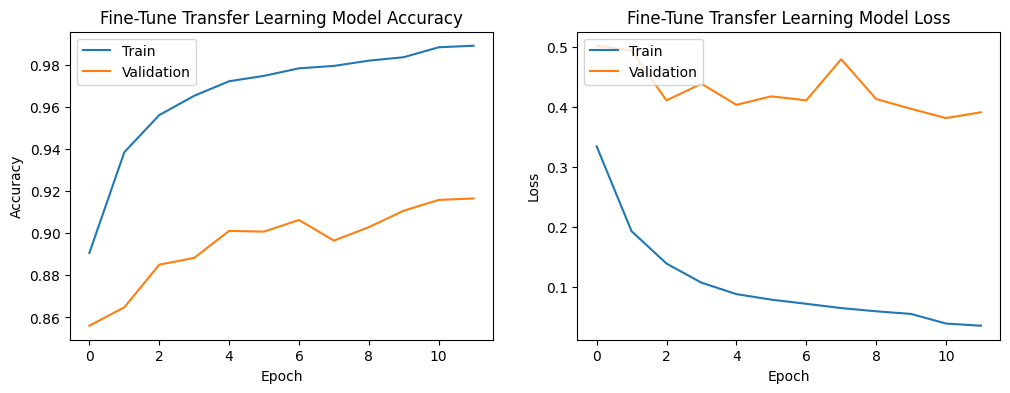

In [ ]:
# Fine-Tune Transfer Learning Model
for layer in base_model.layers[-4:]:
    layer.trainable = True

model_v4 = Model(inputs=base_model.input, outputs=predictions)
model_v4.compile(optimizer=RMSprop(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

model_v4.summary()

history_v4 = model_v4.fit(
    train_generator,
    epochs=12,
    validation_data=validation_generator,
    callbacks=[early_stopping, ModelCheckpoint('best_model_v4.h5', monitor='val_loss', save_best_only=True), lr_scheduler]
)

plot_history(history_v4, 'Fine-Tune Transfer Learning Model')


## Fine-Tuning the Transfer Learning Model

### Changes Made

1. **Unfreezing Specific Layers:**
   - **Unfreezing the Last 4 Layers:**
     - The last 4 layers of the VGG16 base model are set to be trainable. This means that only these specific layers will have their weights updated during training, while the rest of the layers will remain frozen with the pre-trained weights.

2. **Optimizer and Learning Rate:**
   - **Changing to RMSprop with a Lower Learning Rate:**
     - The optimizer is changed to RMSprop with a learning rate of 0.00001. This lower learning rate is used to fine-tune the model carefully without making large updates to the weights, which can be beneficial when fine-tuning pre-trained models.

### Rationale for Changes

1. **Unfreezing Specific Layers:**
   - **Fine-Tuning for Improved Performance:**
     - By unfreezing the last 4 layers of the VGG16 base model, the model can adjust more specialized features that are closer to the output layers. This allows for fine-tuning the model on the specific characteristics of the ASL alphabet dataset, potentially improving its performance.
     - Fine-tuning only a few layers reduces the risk of overfitting and ensures that the model retains the robust features learned from the ImageNet dataset in the earlier layers.

2. **Using RMSprop with a Lower Learning Rate:**
   - **Careful Weight Updates:**
     - A lower learning rate ensures that the updates to the weights are small, which is crucial during fine-tuning to avoid disrupting the pre-trained weights significantly.
     - RMSprop is effective in handling non-stationary objectives and helps in smoothing out the training process, making it suitable for fine-tuning.



In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    dataset_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


history_v5 = model_v4.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping, ModelCheckpoint('best_model_v5.h5', monitor='val_loss', save_best_only=True), reduce_lr]
)




Found 87000 images belonging to 29 classes.
Found 87000 images belonging to 29 classes.
Epoch 1/10
2719/2719 [==============================] - 585s 214ms/step - loss: 0.9831 - accuracy: 0.8541 - val_loss: 0.1060 - val_accuracy: 0.9779 - lr: 1.0000e-07
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2719/2719 [==============================] - 582s 214ms/step - loss: 0.6779 - accuracy: 0.8560 - val_loss: 0.0815 - val_accuracy: 0.9787 - lr: 1.0000e-07
Epoch 3/10
2719/2719 [==============================] - 582s 214ms/step - loss: 0.5855 - accuracy: 0.8583 - val_loss: 0.0730 - val_accuracy: 0.9791 - lr: 1.0000e-07
Epoch 4/10
2719/2719 [==============================] - 585s 215ms/step - loss: 0.5372 - accuracy: 0.8641 - val_loss: 0.0674 - val_accuracy: 0.9800 - lr: 1.0000e-07
Epoch 5/10
1214/2719 [============>.................] - ETA: 4:16 - loss: 0.5123 - accuracy: 0.8678

## Changes Made for the Fifth Model (Model V5)

### New Callback: ReduceLROnPlateau

1. **ReduceLROnPlateau Callback:**
   - **Addition:**
     - A new callback, `ReduceLROnPlateau`, is introduced to reduce the learning rate when the validation loss plateaus.
   - **Parameters:**
     - **Monitor:** Validation loss (`val_loss`).
     - **Factor:** The learning rate is reduced by a factor of 0.2 when triggered.
     - **Patience:** The model will wait for 2 epochs before reducing the learning rate if no improvement in validation loss is observed.
     - **Min_lr:** The minimum learning rate is set to 0.000001.

### Data Augmentation and Rescaling

1. **Updated ImageDataGenerator for Training Data:**
   - **Increased Augmentation:**
     - **Rotation Range:** Increased to 40 degrees.
     - **Width and Height Shift Range:** Set to 20%.

2. **Separate ImageDataGenerator for Validation Data:**
   - **Rescale Only:**
     - The validation data is rescaled by 1./255, but no augmentation is applied to ensure the validation performance is evaluated on unaltered data.

### Changes to Image Size and Data Generators

1. **Target Size Adjustment:**
   - **Image Size:** The target size for images is reduced from (200, 200) to (150, 150) pixels. This can reduce computational load and training time.

2. **Flow from Directory:**
   - **Training Generator:**
     - The `train_datagen` is used to load and augment the training data from the specified directory.
   - **Validation Generator:**
     - The `validation_datagen` is used to load the validation data from the same directory, with rescaling applied but no augmentation.

### Training Process

1. **Model Training with Updated Callbacks and Generators:**
   - **Training Duration:**
     - The model is trained for 10 epochs.
   - **Callbacks:**
     - The `early_stopping` and `ModelCheckpoint` callbacks are retained.
     - The new `ReduceLROnPlateau` callback is added to adjust the learning rate based on validation loss.

### Rationale for Changes

1. **ReduceLROnPlateau:**
   - **Adaptive Learning Rate:**
     - This callback helps to fine-tune the learning rate during training. By reducing the learning rate when the validation loss plateaus, the model can avoid overshooting the optimal weights and potentially achieve better convergence.

2. **Enhanced Data Augmentation:**
   - **Improving Generalization:**
     - Increasing the data augmentation parameters helps in making the model more robust to variations and transformations, which can improve its generalization to unseen data.

3. **Separate Generators for Training and Validation:**
   - **Consistent Validation:**
     - By not augmenting the validation data, the model's performance is evaluated on unaltered images, providing a clear and consistent measure of its performance.

4. **Reduced Image Size:**
   - **Efficiency:**
     - Reducing the target image size to 150x150 pixels lowers the computational cost, potentially speeding up the training process while still retaining enough information for effective learning.

### Summary

These changes aim to enhance the training process by introducing an adaptive learning rate schedule and increasing data augmentation to improve the model's generalization capabilities. Adjusting the image size and using separate generators for training and validation ensure efficient training and consistent evaluation of model performance.


In [ ]:
# download models to device
from google.colab import files

files.download('best_model_v5.h5')
files.download('best_model_v4.h5')
files.download('best_model_v3.h5')
files.download('best_model_v2.h5')
files.download('best_model.h5')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>